In [14]:
# """
# predicting a sequence of future prices (`n_steps_out`) instead of just one.

# Benefits of This Approach
# Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
# More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
# Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.
# """

time: 338 µs (started: 2024-11-18 19:22:14 +00:00)


In [15]:
!pip install -r requirements.txt -q
!pip install ipython-autotime -q

time: 4.82 s (started: 2024-11-18 19:22:14 +00:00)


In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
tensorflow version: 2.15.0
Num GPUs Available:  1


True

time: 4.43 ms (started: 2024-11-18 19:22:19 +00:00)


In [17]:
# parameter
# n_steps_in: Number of input time steps
# n_steps_out: Number of days to predict ahead

n_steps_in = 14  
n_steps_out = 5
epochs = 50
batch_size = 32

time: 288 µs (started: 2024-11-18 19:22:19 +00:00)


In [18]:
def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data('processed_data')
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,SMA7,SMA14,...,EMA7,EMA25,EMA99,EMA200,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-19 00:00:00+00:00,25.937435,28.752501,29.129999,28.670000,29.025000,193146000,38.868505,-58.647164,28.875357,29.083214,...,29.011843,29.811806,30.819353,30.361521,-0.639367,-59.662038,30.115768,28.050661,8.949397,28.162500
2015-08-20 00:00:00+00:00,25.405201,28.162500,28.587500,27.907499,28.520000,274006400,34.842467,-76.661486,28.845357,28.928750,...,28.799508,29.684936,30.766216,30.339640,-0.675706,-101.719165,29.807586,28.049914,8.822285,26.440001
2015-08-21 00:00:00+00:00,23.851353,26.440001,27.975000,26.412500,27.607500,513102000,26.282999,-99.232910,28.506786,28.702321,...,28.209631,29.435326,30.679692,30.300837,-0.833884,-193.641185,30.187027,27.217616,8.940749,25.780001
2015-08-24 00:00:00+00:00,23.255964,25.780001,27.200001,23.000000,23.717501,648825200,23.863926,-60.271513,28.077143,28.496607,...,27.602223,29.154147,30.581698,30.255854,-1.000959,-286.791374,30.611922,26.381293,9.012688,25.934999
2015-08-25 00:00:00+00:00,23.395788,25.934999,27.777500,25.875000,27.777500,414406400,25.595895,-58.056453,27.640715,28.288393,...,27.185417,28.906520,30.488764,30.212860,-1.108087,-175.033141,30.766350,25.810436,9.087065,27.422501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25 00:00:00+00:00,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,233.175714,231.504286,...,232.117849,229.678046,219.220789,207.361942,2.040117,34.671127,237.405189,225.603382,1.664750,233.399994
2024-10-28 00:00:00+00:00,233.143494,233.399994,234.729996,232.550003,233.320007,36087100,56.742652,-32.306559,233.354285,232.049285,...,232.438385,229.964350,219.504373,207.621027,2.033819,76.852796,237.075664,227.022906,1.484857,233.669998


time: 68.5 ms (started: 2024-11-18 19:22:19 +00:00)


In [19]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Remove 'Close Next Day' from features (last column)
        features = scaled_values[:, :-1]  # All columns except the last one
        targets = scaled_values[:, -1]    # Only the last column
        
        # Split into train/validation
        n_train = int(len(features) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(features)} samples is too short for meaningful splitting")
            continue
            
        # Split features and targets
        train_features = features[:n_train]
        train_targets = targets[:n_train]
        val_features = features[n_train:]
        val_targets = targets[n_train:]
        
        # Create sequences
        if len(train_features) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(train_features, train_targets, n_steps_in, n_steps_out)
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_features) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(val_features, val_targets, n_steps_in, n_steps_out)
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(values_list, n_steps_in, n_steps_out, train_split=0.8)

Training shapes: X=(34865, 14, 20), y=(34865, 5)
Validation shapes: X=(8474, 14, 20), y=(8474, 5)
Number of features: 20
time: 83.9 ms (started: 2024-11-18 19:22:19 +00:00)


In [20]:
def custom_loss(y_true, y_pred):
    # Combine MSE with directional accuracy
    mse = tf.keras.losses.MeanSquaredError(y_true, y_pred)
    
    # Direction loss (penalize wrong direction predictions more)
    direction_true = tf.sign(y_true[..., 1:] - y_true[..., :-1])
    direction_pred = tf.sign(y_pred[..., 1:] - y_pred[..., :-1])
    direction_loss = tf.keras.losses.MeanAbsoluteError(direction_true, direction_pred)
    return mse + 0.2 * direction_loss


def create_lstm_model(n_steps_in, n_features, n_steps_out):
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features), kernel_initializer='he_normal'),
        LSTM(50, activation='relu', kernel_initializer='he_normal'),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = [tf.keras.losses.MeanSquaredError(name='mse')]
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    model.compile(optimizer=optimizer, loss_weights=[100], loss=loss, metrics=metrics)
    model.summary()
    
    return model

# Create and train model
model = create_lstm_model(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 100)           48400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 78855 (308.03 KB)
Trainable params: 78855 (308.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 176 ms (started: 2024-11-18 19:22:19 +00:00)


In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    shuffle=False
)

Epoch 1/50
1090/1090 - 26s - loss: 0.5392 - rmse: 0.0734 - val_loss: 0.2882 - val_rmse: 0.0537 - 26s/epoch - 24ms/step
Epoch 2/50
1090/1090 - 24s - loss: 0.0736 - rmse: 0.0271 - val_loss: 0.1761 - val_rmse: 0.0420 - 24s/epoch - 22ms/step
Epoch 3/50
1090/1090 - 24s - loss: 0.0483 - rmse: 0.0220 - val_loss: 0.1358 - val_rmse: 0.0368 - 24s/epoch - 22ms/step
Epoch 4/50
1090/1090 - 24s - loss: 0.0377 - rmse: 0.0194 - val_loss: 0.1406 - val_rmse: 0.0375 - 24s/epoch - 22ms/step
Epoch 5/50
1090/1090 - 24s - loss: 0.0348 - rmse: 0.0186 - val_loss: 0.1127 - val_rmse: 0.0336 - 24s/epoch - 22ms/step
Epoch 6/50
1090/1090 - 24s - loss: 0.0259 - rmse: 0.0161 - val_loss: 0.1084 - val_rmse: 0.0329 - 24s/epoch - 22ms/step
Epoch 7/50
1090/1090 - 27s - loss: 0.0280 - rmse: 0.0167 - val_loss: 0.1079 - val_rmse: 0.0328 - 27s/epoch - 24ms/step
Epoch 8/50
1090/1090 - 24s - loss: 0.0218 - rmse: 0.0148 - val_loss: 0.1004 - val_rmse: 0.0317 - 24s/epoch - 22ms/step
Epoch 9/50
1090/1090 - 25s - loss: 0.0206 - rmse

In [27]:
# Make predictions
y_pred = model.predict(val_X)
print(y_pred.shape)

# Evaluate for each time step
for i in range(n_steps_out):
    mse = mean_squared_error(val_y[:, i], y_pred[:, i])
    print(f"MSE for step {i+1}: {mse: .4f}")

265/265 [==============================] - 1s 4ms/step
(8474, 5)
MSE for step 1:  0.0005
MSE for step 2:  0.0005
MSE for step 3:  0.0008
MSE for step 4:  0.0010
MSE for step 5:  0.0011
time: 1.24 s (started: 2024-11-18 20:35:22 +00:00)


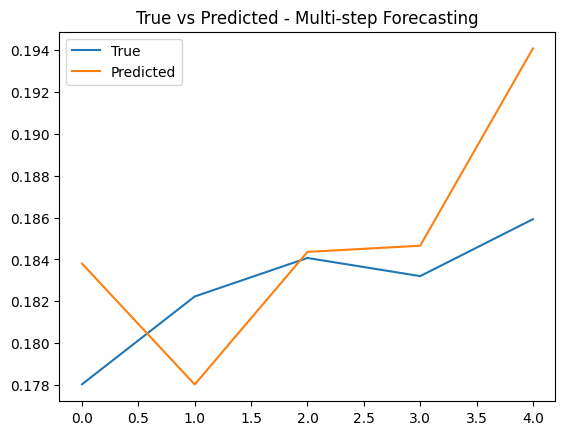

time: 119 ms (started: 2024-11-18 20:35:23 +00:00)


In [28]:
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()

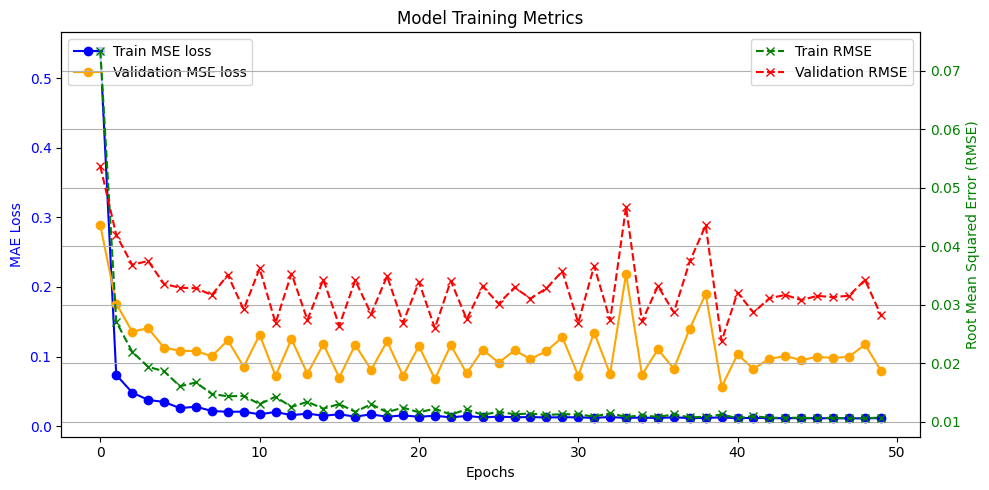

time: 205 ms (started: 2024-11-18 20:35:26 +00:00)


In [29]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Loss plot
N = len(history.history["loss"])
epoch_range = np.arange(0, N)

ax1.plot(epoch_range, history.history["loss"], label='Train MSE loss', marker='o', color='blue')
ax1.plot(epoch_range, history.history["val_loss"], label='Validation MSE loss', marker='o', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# RMSE plot (shared x-axis, different y-axis)
ax2 = ax1.twinx()
ax2.plot(epoch_range, history.history["rmse"], label='Train RMSE', marker='x', color='green', linestyle='--')
ax2.plot(epoch_range, history.history["val_rmse"], label='Validation RMSE', marker='x', color='red', linestyle='--')
ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.title('Model Training Metrics')
plt.grid()
plt.tight_layout()
plt.show()


Analyzing AAPL...

Evaluation Metrics for AAPL:
MSE: 67.9892
RMSE: 8.2456
MAE: 7.2662


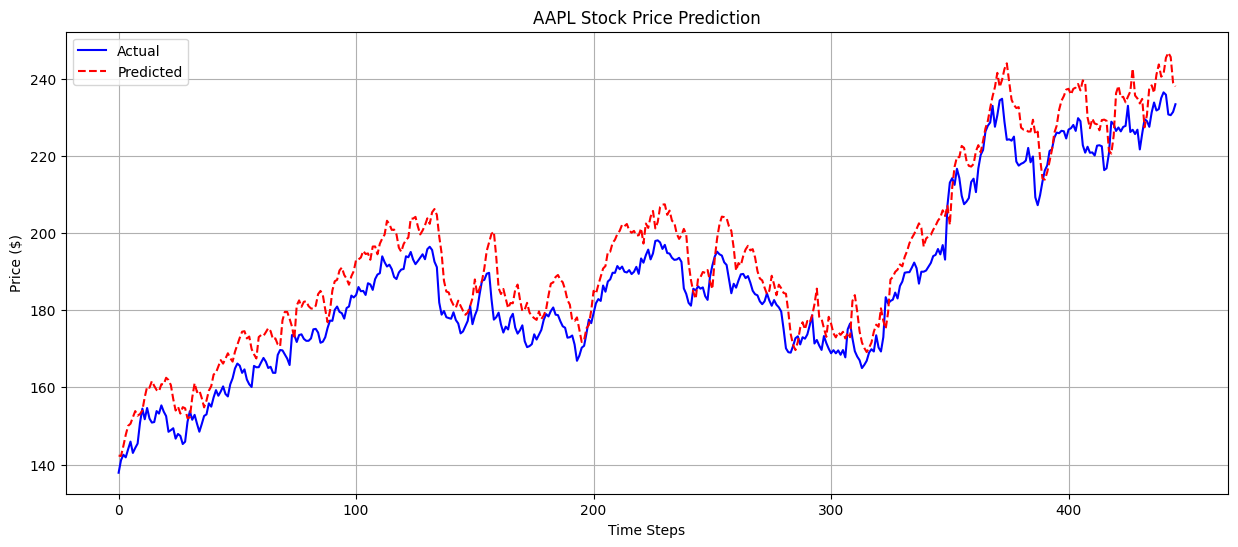


Analyzing AMZN...

Evaluation Metrics for AMZN:
MSE: 65.1051
RMSE: 8.0688
MAE: 7.1827


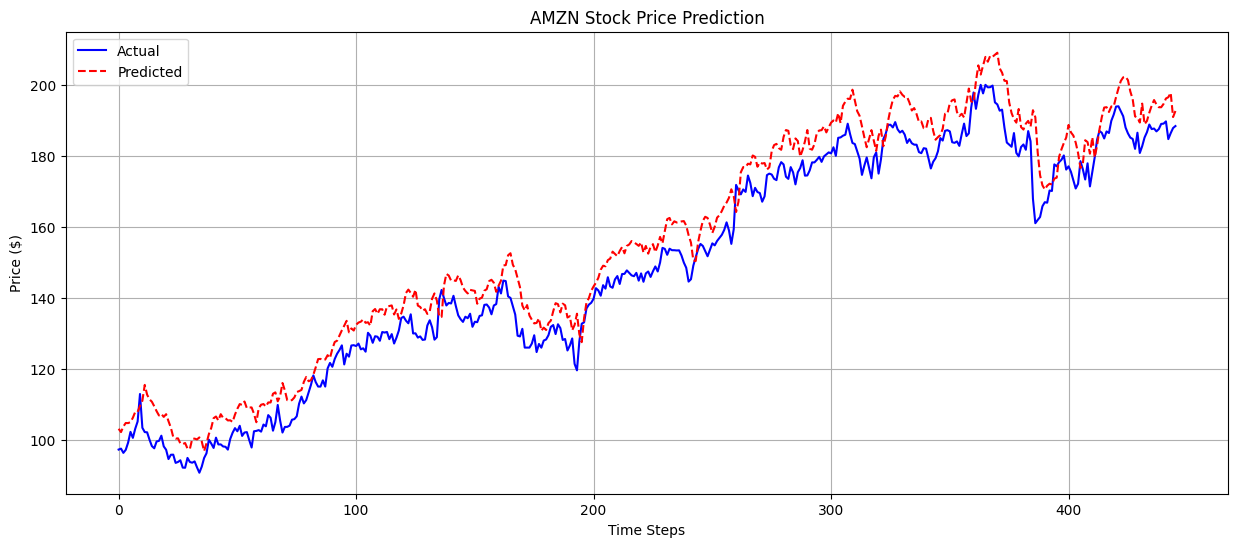


Analyzing GME...

Evaluation Metrics for GME:
MSE: 32.9421
RMSE: 5.7395
MAE: 5.2371


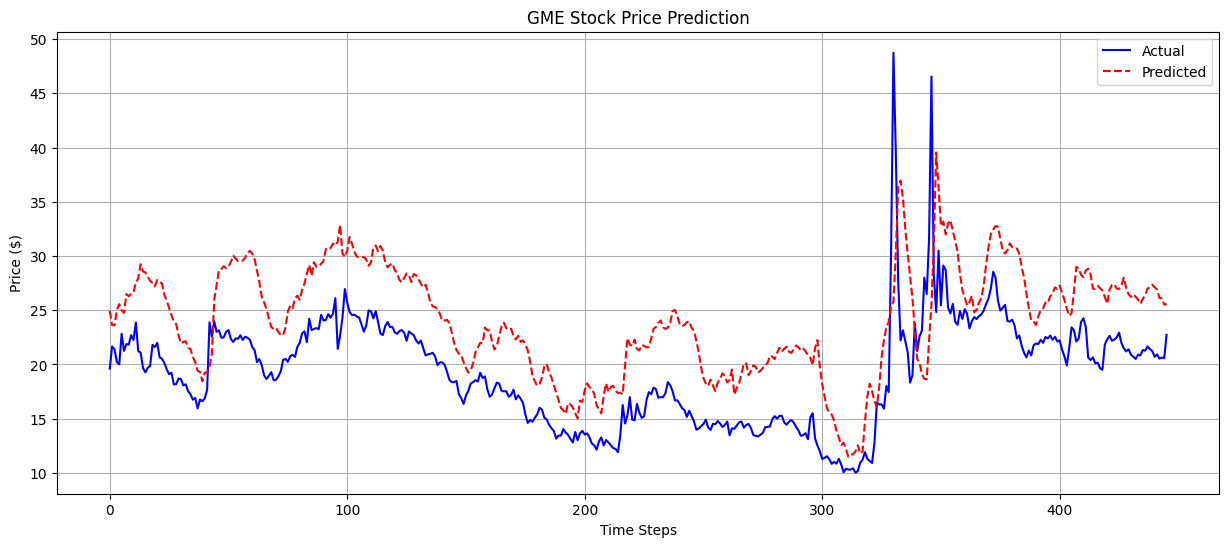


Analyzing GOOGL...

Evaluation Metrics for GOOGL:
MSE: 57.2784
RMSE: 7.5682
MAE: 6.6900


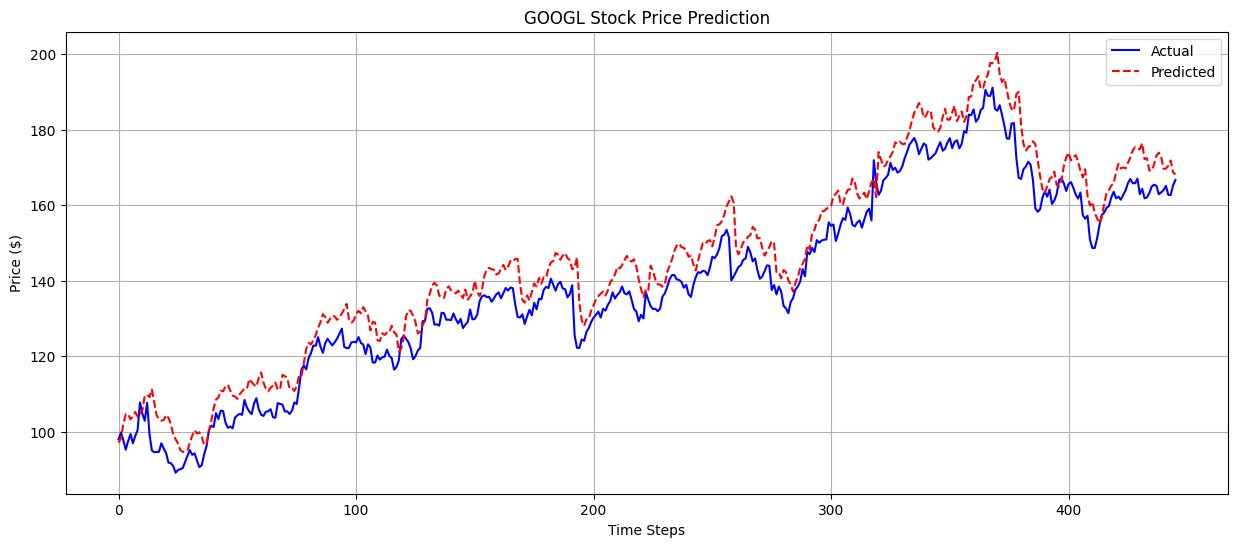


Analyzing NFLX...

Evaluation Metrics for NFLX:
MSE: 2834.1644
RMSE: 53.2369
MAE: 39.8014


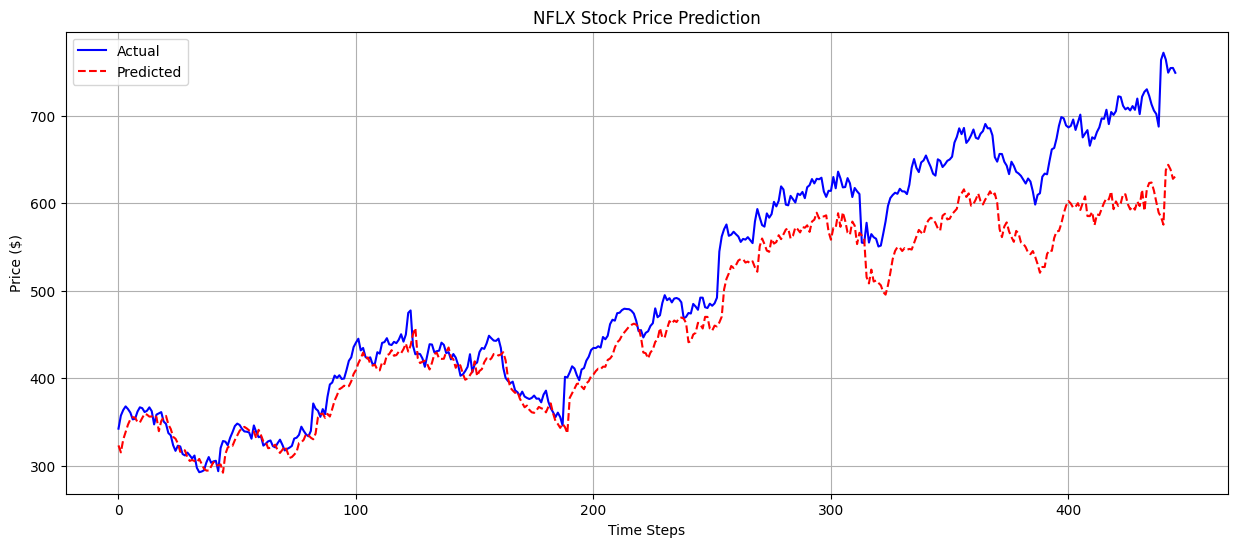


Analyzing TSLA...

Evaluation Metrics for TSLA:
MSE: 157.2763
RMSE: 12.5410
MAE: 9.7121


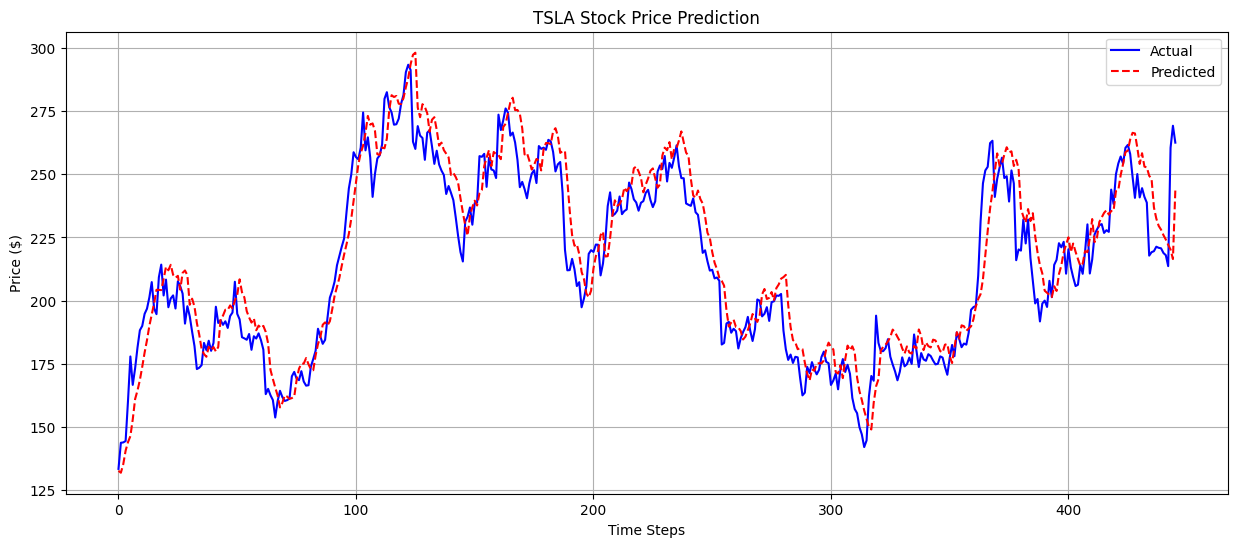


Analyzing MSFT...

Evaluation Metrics for MSFT:
MSE: 208.0348
RMSE: 14.4234
MAE: 11.1906


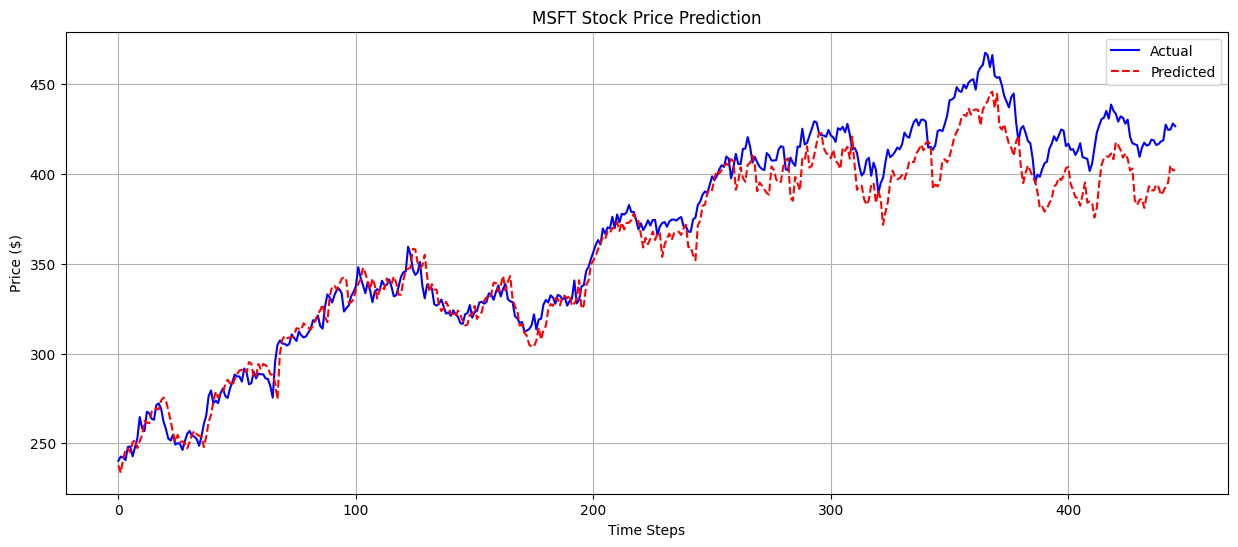


Analyzing NVDA...

Evaluation Metrics for NVDA:
MSE: 119.4289
RMSE: 10.9284
MAE: 10.1734


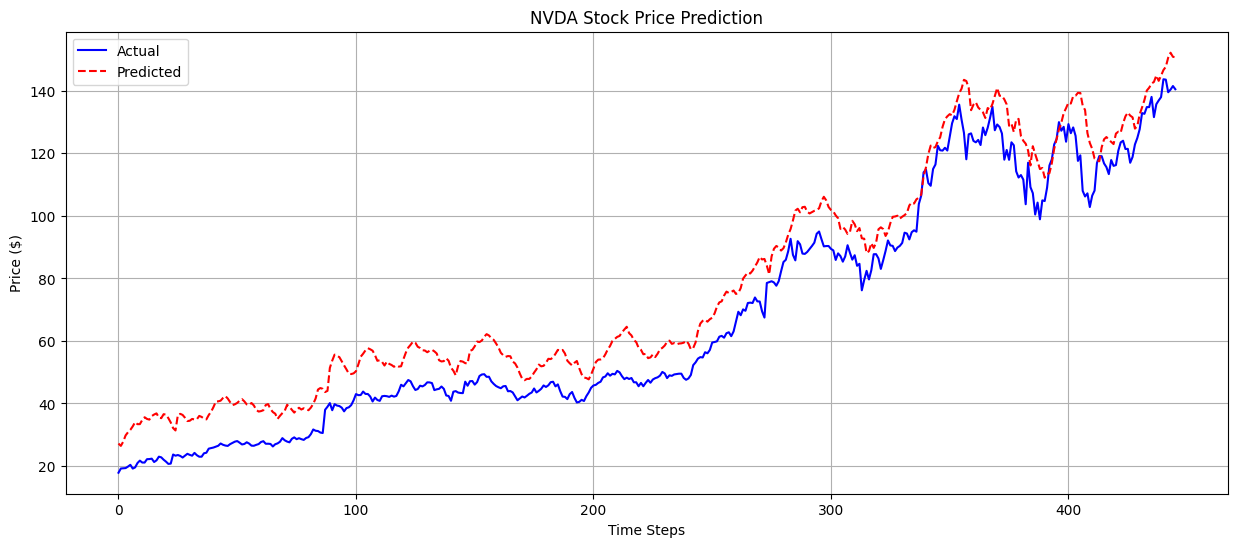


Analyzing AMD...

Evaluation Metrics for AMD:
MSE: 83.6862
RMSE: 9.1480
MAE: 7.5729


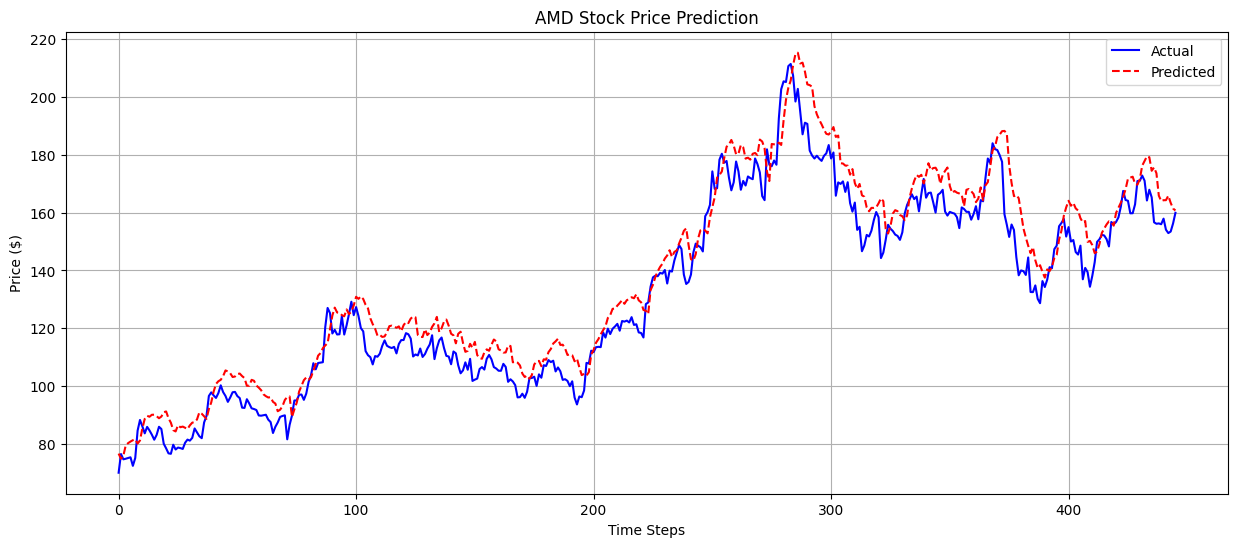


Analyzing CRM...

Evaluation Metrics for CRM:
MSE: 76.0625
RMSE: 8.7214
MAE: 6.8316


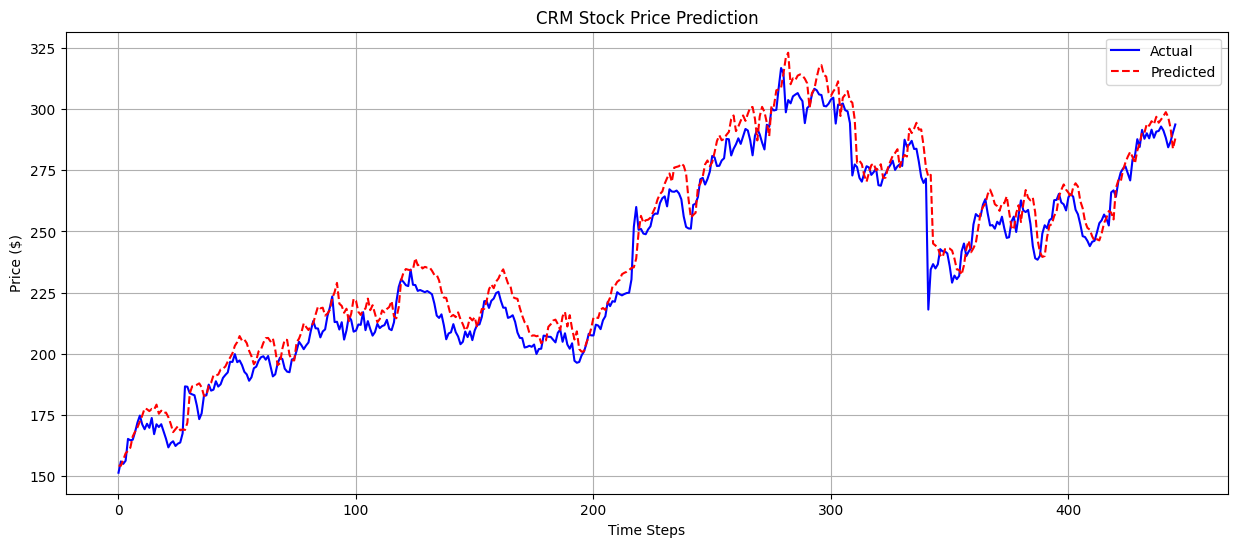


Analyzing JPM...

Evaluation Metrics for JPM:
MSE: 57.1107
RMSE: 7.5572
MAE: 6.7370


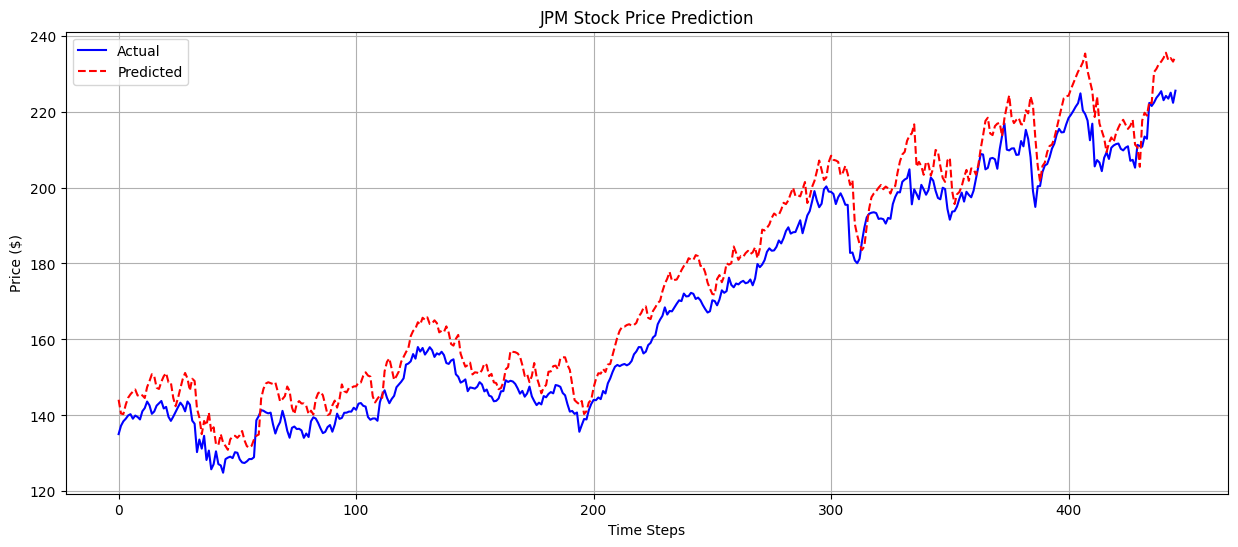


Analyzing V...

Evaluation Metrics for V:
MSE: 56.3976
RMSE: 7.5098
MAE: 6.4023


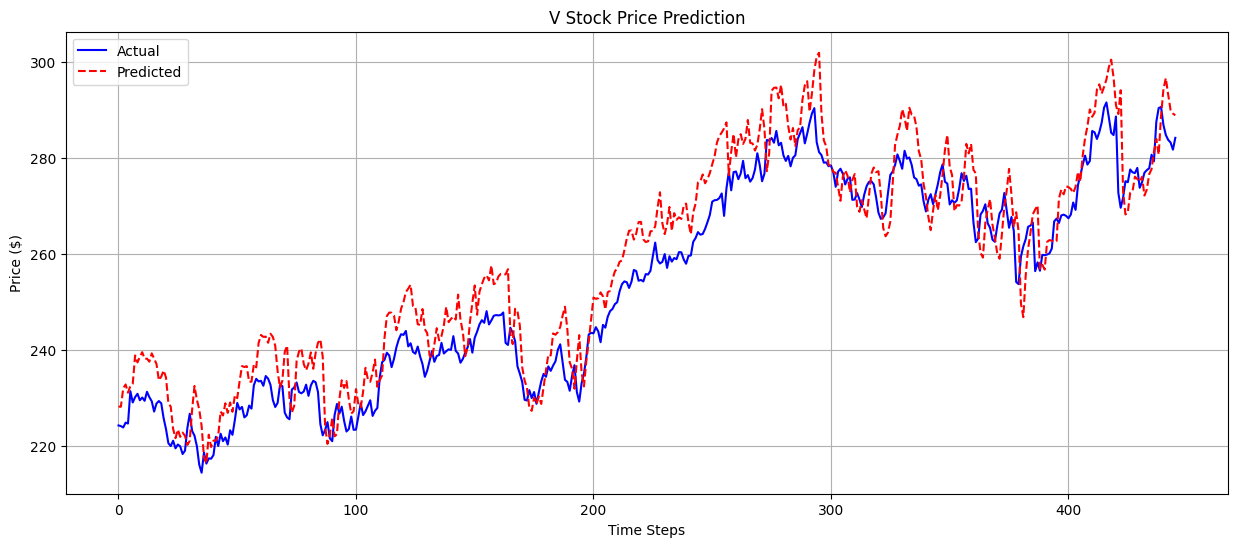


Analyzing MA...

Evaluation Metrics for MA:
MSE: 669.1348
RMSE: 25.8676
MAE: 22.8670


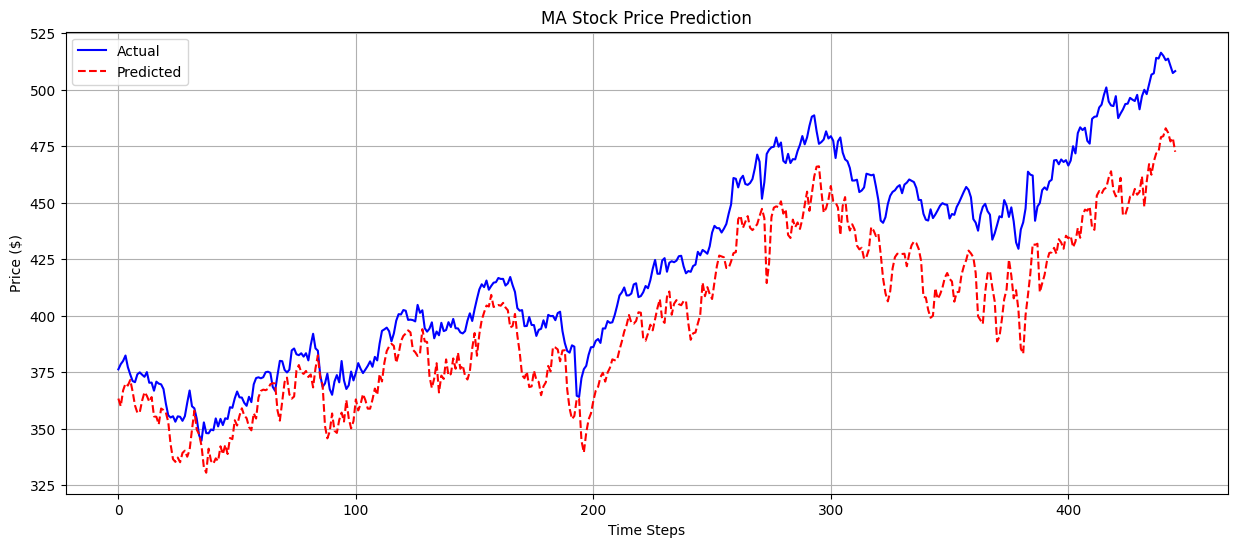


Analyzing MSTR...

Evaluation Metrics for MSTR:
MSE: 120.2779
RMSE: 10.9671
MAE: 8.1294


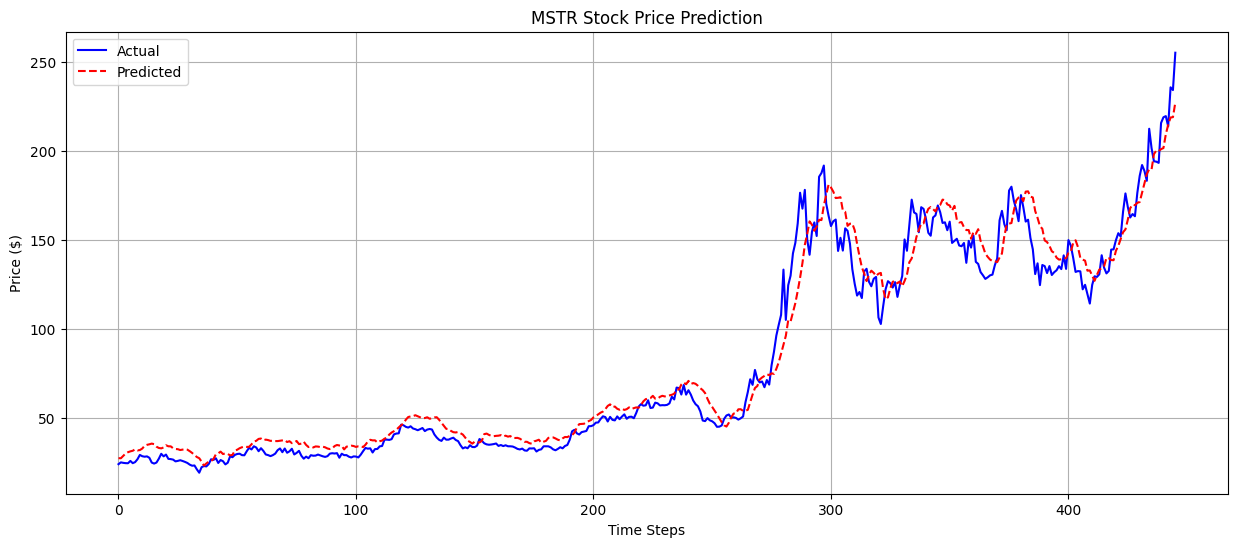


Analyzing DIS...

Evaluation Metrics for DIS:
MSE: 43.4088
RMSE: 6.5885
MAE: 6.1172


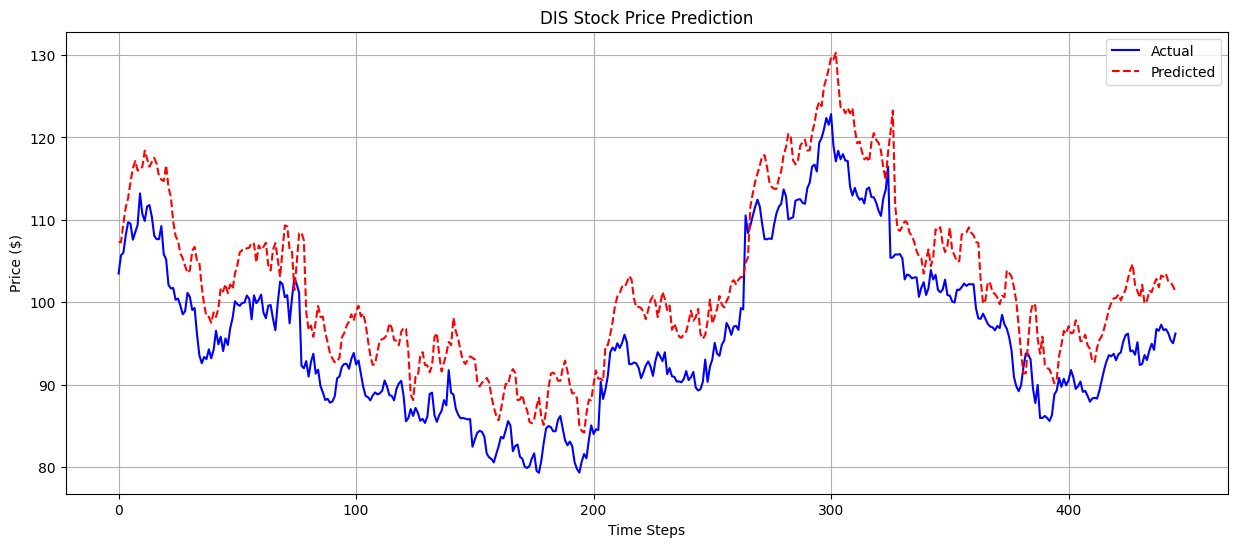


Analyzing BA...

Evaluation Metrics for BA:
MSE: 68.1663
RMSE: 8.2563
MAE: 6.6684


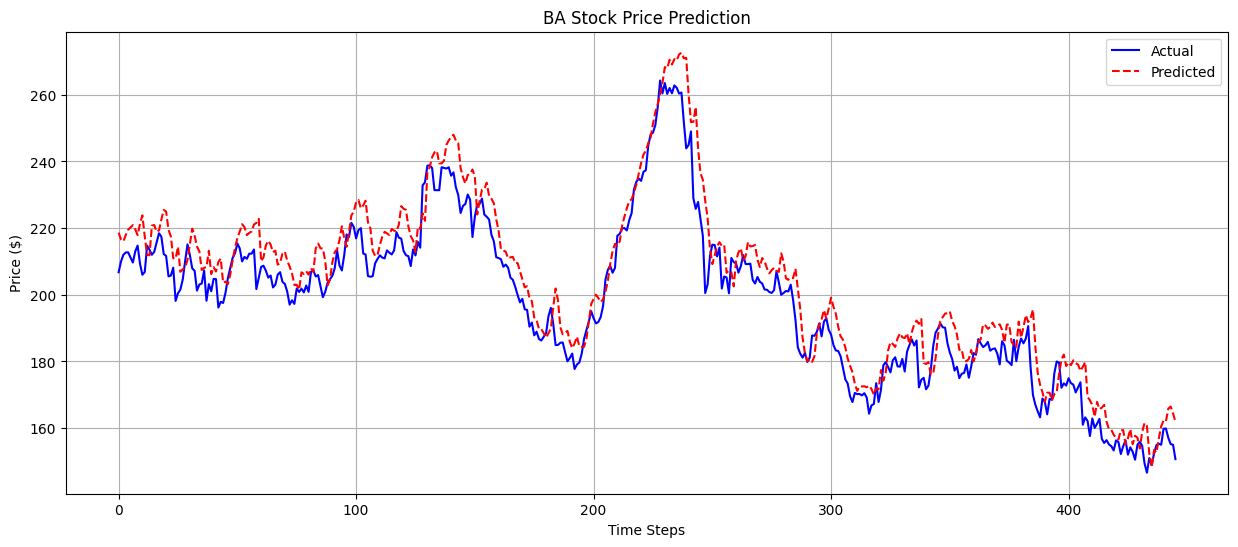


Analyzing XOM...

Evaluation Metrics for XOM:
MSE: 45.6321
RMSE: 6.7552
MAE: 6.2647


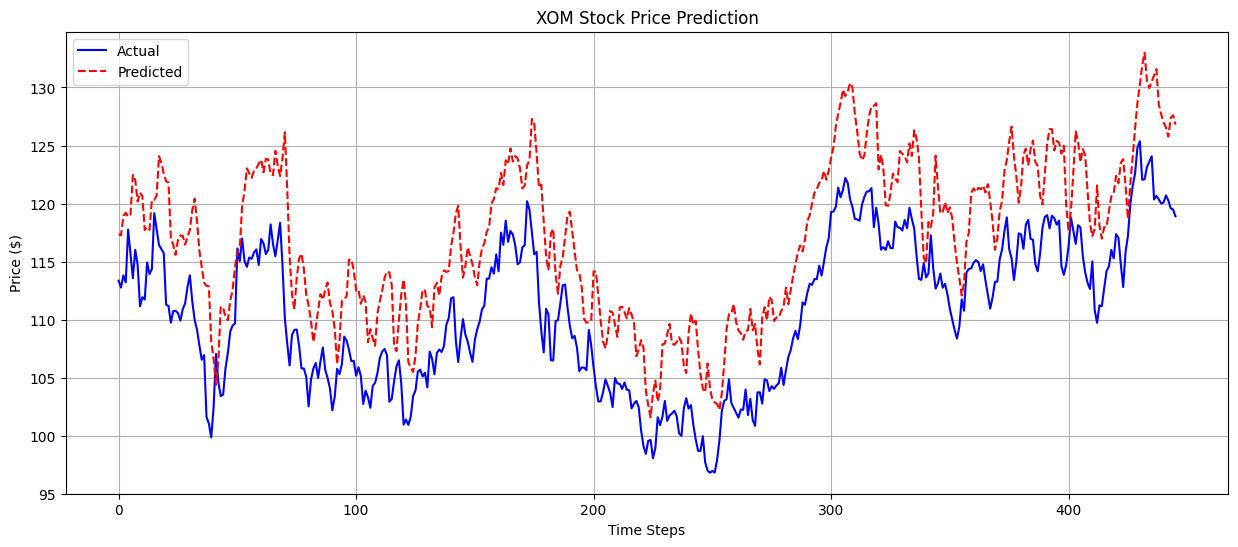


Analyzing ORCL...

Evaluation Metrics for ORCL:
MSE: 48.8684
RMSE: 6.9906
MAE: 6.3063


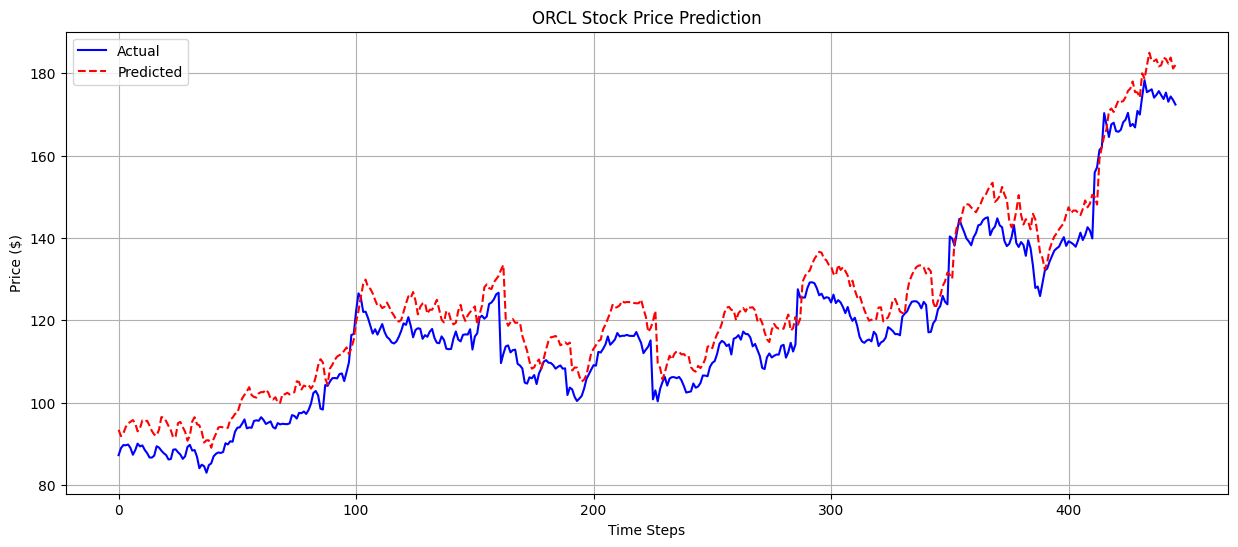


Analyzing META...

Evaluation Metrics for META:
MSE: 450.2001
RMSE: 21.2179
MAE: 15.5386


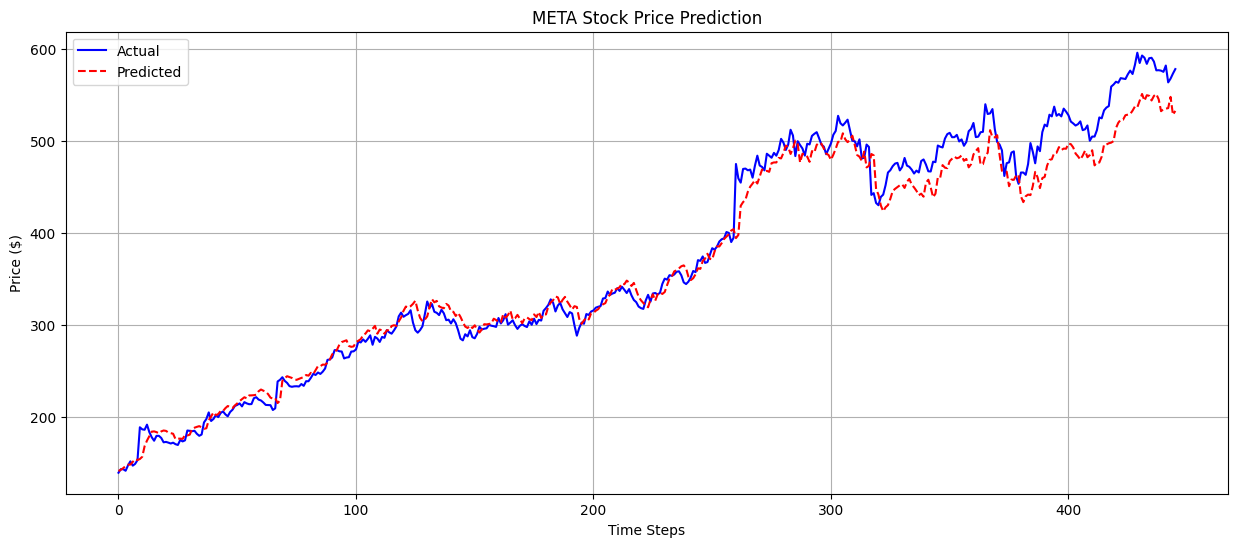


Summary of Metrics for All Stocks:
               MSE       RMSE        MAE
AAPL     67.989152   8.245553   7.266217
AMZN     65.105100   8.068773   7.182729
GME      32.942085   5.739520   5.237062
GOOGL    57.278390   7.568249   6.690025
NFLX   2834.164448  53.236871  39.801379
TSLA    157.276280  12.540984   9.712129
MSFT    208.034761  14.423410  11.190646
NVDA    119.428868  10.928352  10.173436
AMD      83.686177   9.148015   7.572881
CRM      76.062513   8.721383   6.831559
JPM      57.110742   7.557165   6.736959
V        56.397615   7.509835   6.402310
MA      669.134812  25.867640  22.867035
MSTR    120.277878  10.967127   8.129354
DIS      43.408823   6.588537   6.117248
BA       68.166308   8.256289   6.668441
XOM      45.632104   6.755154   6.264696
ORCL     48.868368   6.990591   6.306318
META    450.200071  21.217919  15.538630
time: 4.89 s (started: 2024-11-18 20:35:27 +00:00)


In [30]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 'BA', 'XOM', 'ORCL', 'META']

def split_validation_data(val_X, val_y, stock_lengths):
    """
    Split the combined validation data back into individual stocks.
    
    Args:
        val_X: Combined validation features
        val_y: Combined validation targets
        stock_lengths: List of number of validation samples for each stock
        
    Returns:
        tuple: Lists of validation X and y for each stock
    """
    val_X_stocks = []
    val_y_stocks = []
    
    start_idx = 0
    for length in stock_lengths:
        val_X_stocks.append(val_X[start_idx:start_idx + length])
        val_y_stocks.append(val_y[start_idx:start_idx + length])
        start_idx += length
        
    return val_X_stocks, val_y_stocks

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day)
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate validation set lengths for each stock
def get_stock_val_lengths(values_list, train_split=0.8, n_steps_in=14, n_steps_out=5):
    """
    Calculate the number of validation samples for each stock
    """
    val_lengths = []
    for values in values_list:
        n_train = int(len(values) * train_split)
        val_data = values[n_train:]
        n_sequences = len(val_data) - n_steps_in - n_steps_out + 1
        if n_sequences > 0:
            val_lengths.append(n_sequences)
    return val_lengths

# Calculate validation lengths for each stock
val_lengths = get_stock_val_lengths(values_list)

# Split validation data back into individual stocks
val_X_stocks, val_y_stocks = split_validation_data(val_X, val_y, val_lengths)

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_stocks[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {
        'actual': val_y_stocks[i],
        'predicted': val_predictions
    }
    
    # Calculate metrics (using first day predictions)
    mse, rmse, mae = evaluate_predictions(
        val_y_stocks[i][:, 0],  # First day actual
        val_predictions[:, 0],   # First day predictions
        ticker,
        scaler
    )
    
    metrics_dict[ticker] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Plot predictions (first day)
    plot_predictions(
        val_y_stocks[i][:, 0],    # First day actual
        val_predictions[:, 0],     # First day predictions
        ticker,
        scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)

In [26]:
def plot_future_predictions(historical_data, future_preds, actual_prices, ticker, scaler):
    """
    Plot historical data, future predictions, and actual prices in different colors
    
    Parameters:
    - historical_data: Historical price data
    - future_preds: Model's price predictions
    - actual_prices: Actual prices for the prediction period
    - ticker: Stock ticker symbol
    - scaler: The scaler used to transform the data
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    historical_prices = inverse_transform_price(historical_data, scaler)
    future_prices = inverse_transform_price(future_preds.flatten(), scaler)
    actual_future_prices = inverse_transform_price(actual_prices.flatten(), scaler)
    
    # Plot historical data
    plt.plot(range(len(historical_prices)), historical_prices, label='Historical', color='blue')
    
    # Plot predictions
    connection_indices = range(len(historical_prices)-1, len(historical_prices) + len(future_prices))
    connection_points = np.concatenate([historical_prices[-1:], future_prices])
    plt.plot(connection_indices, connection_points, label='Predicted', color='red', linestyle='--')
    
    # Plot actual future prices (starting from the last historical point)
    actual_indices = range(len(historical_prices)-1, len(historical_prices) + len(actual_future_prices))
    actual_points = np.concatenate([historical_prices[-1:], actual_future_prices])
    plt.plot(actual_indices, actual_points, label='Actual', color='green', linewidth=2)
    
    plt.title(f'{ticker} Stock Price - Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


def predict_future(model, last_sequence, n_steps_out, n_features):
    """
    Make future predictions using the last known sequence
    
    Args:
        model: trained LSTM model
        last_sequence: last known sequence of data (shape: [n_steps_in, n_features])
        n_steps_out: number of future steps to predict
        n_features: number of features in the input data
    """
    future_predictions = []
    current_sequence = last_sequence.reshape(1, n_steps_in, n_features)
    
    for _ in range(n_steps_out):
        # Get prediction for next step
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0])
        
        # Update the sequence by removing the first timestep and adding the prediction
        # We'll repeat the last prediction across all features as an approximation
        new_row = np.repeat(next_pred[0][0], n_features).reshape(1, 1, n_features)
        current_sequence = np.concatenate([current_sequence[:, 1:, :], new_row], axis=1)
    
    return np.array(future_predictions)

# Future predictions
print("\nMaking Future Predictions...")
n_features = train_X.shape[2]

for i, ticker in enumerate(tickers):
    print(f"\nPredicting future prices for {ticker}...")
    
    # Get the last sequence from the validation data
    last_sequence = val_X[i][-1]
    
    # Make future predictions
    future_preds = predict_future(model, last_sequence, n_steps_out, n_features)
    
    # Get recent historical data for plotting (last 30 days)
    historical_data = val_y[i][-30:, 0]
    
    # Get actual future prices for comparison (next n_steps_out days)
    actual_future_prices = val_y[i][-n_steps_out:]
    
    # Print actual price predictions
    future_prices = inverse_transform_price(future_preds.flatten(), global_scaler)
    print(f"\n{ticker} - Next {n_steps_out} days price predictions:")
    for day, price in enumerate(future_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Print actual prices for comparison
    actual_prices = inverse_transform_price(actual_future_prices.flatten(), global_scaler)
    print(f"\n{ticker} - Actual prices for comparison:")
    for day, price in enumerate(actual_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Plot future predictions with historical context and actual prices
    try:
        plot_future_predictions(historical_data,future_preds,actual_future_prices,ticker,global_scaler)
    except Exception as e:
        print(f"Error plotting predictions for {ticker}: {e}")
        continue



Making Future Predictions...

Predicting future prices for AAPL...


ValueError: cannot reshape array of size 20 into shape (1,14,20)

time: 36.3 ms (started: 2024-11-18 19:43:08 +00:00)
